In [1]:
# matplotlib 显示中文
import matplotlib.pyplot as plt

# 设置matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [2]:
import os
import torch
import numpy as np
from PIL import Image

In [3]:
def visualize_results(images, image_paths, texts_zh, texts_en, probs_zh, probs_en):
    """可视化CLIP匹配结果，中英文并排显示"""
    n_images = len(images)
    n_texts = len(texts_zh)
    
    # 创建足够大的图形
    plt.figure(figsize=(24, 7 * n_images))

    for i in range(n_images):
        # 显示图像
        plt.subplot(n_images, 3, i*3+1)
        plt.imshow(images[i])
        plt.title(f"图像 {i+1}: {os.path.basename(image_paths[i])}")
        plt.axis('off')
        
        # 显示中文匹配概率条形图
        probs_data_zh = probs_zh[i].cpu().detach().numpy()
        plt.subplot(n_images, 3, i*3+2)
        y_pos = np.arange(n_texts)
        plt.barh(y_pos, probs_data_zh)
        plt.yticks(y_pos, texts_zh)
        plt.xlabel('匹配概率')
        plt.title(f'图像 {i+1} 的中文文本匹配概率')
        
        # 查找中文最高概率的文本
        best_match_idx_zh = torch.argmax(probs_zh[i]).item()
        plt.plot([0, probs_data_zh[best_match_idx_zh]], [best_match_idx_zh, best_match_idx_zh], 
                 'r', linewidth=2)
        
        # 显示英文匹配概率条形图
        probs_data_en = probs_en[i].cpu().detach().numpy()
        plt.subplot(n_images, 3, i*3+3)
        plt.barh(y_pos, probs_data_en)
        plt.yticks(y_pos, texts_en)
        plt.xlabel('Matching Probability')
        plt.title(f'Image {i+1} Text Matching Probability (English)')
        
        # 查找英文最高概率的文本
        best_match_idx_en = torch.argmax(probs_en[i]).item()
        plt.plot([0, probs_data_en[best_match_idx_en]], [best_match_idx_en, best_match_idx_en], 
                 'r', linewidth=2)
        
    plt.tight_layout()
    # plt.savefig('./clip_results_bilingual.png', dpi=150, bbox_inches='tight')
    # print("可视化结果已保存到 clip_results_bilingual.png")
    plt.show()

In [4]:
def load_image_from_path(image_path):
    """从本地路径加载图片"""
    if os.path.exists(image_path):
        return Image.open(image_path).convert('RGB')
    else:
        print(f"警告：无法找到图像文件 {image_path}")
        return None

def main(model, processor):
    # 准备示例图片路径
    image_paths = [
        "./images/打篮球_二次元.jpeg",
        "./images/两只猫.jpg",
        "./images/玫瑰花.png",
        "./images/皮卡丘.jpeg",
    ]

    # 加载图像
    images = []
    for path in image_paths:
        img = load_image_from_path(path)
        if img:
            images.append(img)

    if not images:
        print("错误：没有找到任何有效的图像文件")

    # 准备文本描述
    texts_zh = [
        "一只可爱的橘猫",
        "两只可爱的橘猫",
        "一只黑白相间的狗",
        "一只黄色的皮卡丘",
        "一个正在打篮球的人",
        "一朵红色的玫瑰花",
        "一辆红色的跑车",
        "一只白色的兔子",
        "一个正在弹钢琴的人"
    ]

    texts_en = [
        "a cute orange cat",
        "two cute orange cats",
        "a cute dog with white and black fur",
        "a yellow pikachu",
        "a person playing basketball",
        "a red rose",
        "a red sports car",
        "a white rabbit",
        "a person playing piano"
    ]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print("处理中文和英文文本...")
    with torch.no_grad(): 
        try:
            inputs_zh = processor(images=images, text=texts_zh, return_tensors="pt", padding=True).to(device)
            outputs_zh = model(**inputs_zh)
            logits_per_image_zh = outputs_zh.logits_per_image
            probs_zh = logits_per_image_zh.softmax(dim=1)
            
            # 处理英文文本
            inputs_en = processor(images=images, text=texts_en, return_tensors="pt", padding=True).to(device)
            outputs_en = model(**inputs_en)
            logits_per_image_en = outputs_en.logits_per_image
            probs_en = logits_per_image_en.softmax(dim=1)

            # 使用matplotlib可视化结果
            visualize_results(images, image_paths, texts_zh, texts_en, probs_zh, probs_en)
        
        except Exception as e:
            print(f"处理数据时发生错误: {str(e)}")
            import traceback
            traceback.print_exc()


In [5]:
from transformers import CLIPProcessor, CLIPModel

# 加载CLIP模型和处理器
print("正在加载CLIP模型...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# 支持的模型：https://huggingface.co/openai
# 1. openai/clip-vit-base-patch32
# 2. openai/clip-vit-base-patch16
# 3. openai/clip-vit-large-patch14
# 4. openai/clip-vit-large-patch14-336

/home/hey/anaconda3/envs/minimind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在加载CLIP模型...


In [6]:
# 定义要分词的文本
text = "一只可爱的橘猫"
# 使用处理器的分词器进行分词
inputs = processor.tokenizer(text, return_tensors="pt")
# 获取分词后的输入 ID
input_ids = inputs["input_ids"].squeeze()
# 将输入 ID 转换为分词结果
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

text = "a cute orange cat"
inputs = processor.tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].squeeze()
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['<|startoftext|>', 'ä¸', 'Ģ', 'åı', 'ª', 'åı', '¯', 'ç', 'Ī', '±', 'ç', 'ļ', 'Ħ', 'æ', '©', 'ĺ', 'ç', 'Į', '«</w>', '<|endoftext|>']
['<|startoftext|>', 'a</w>', 'cute</w>', 'orange</w>', 'cat</w>', '<|endoftext|>']


In [7]:
print(f"模型路径: {model.config._name_or_path}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
print(f"词表大小: {model.config.text_config.vocab_size}")

模型路径: openai/clip-vit-base-patch16
模型参数量: 149.62M
词表大小: 49408


处理中文和英文文本...


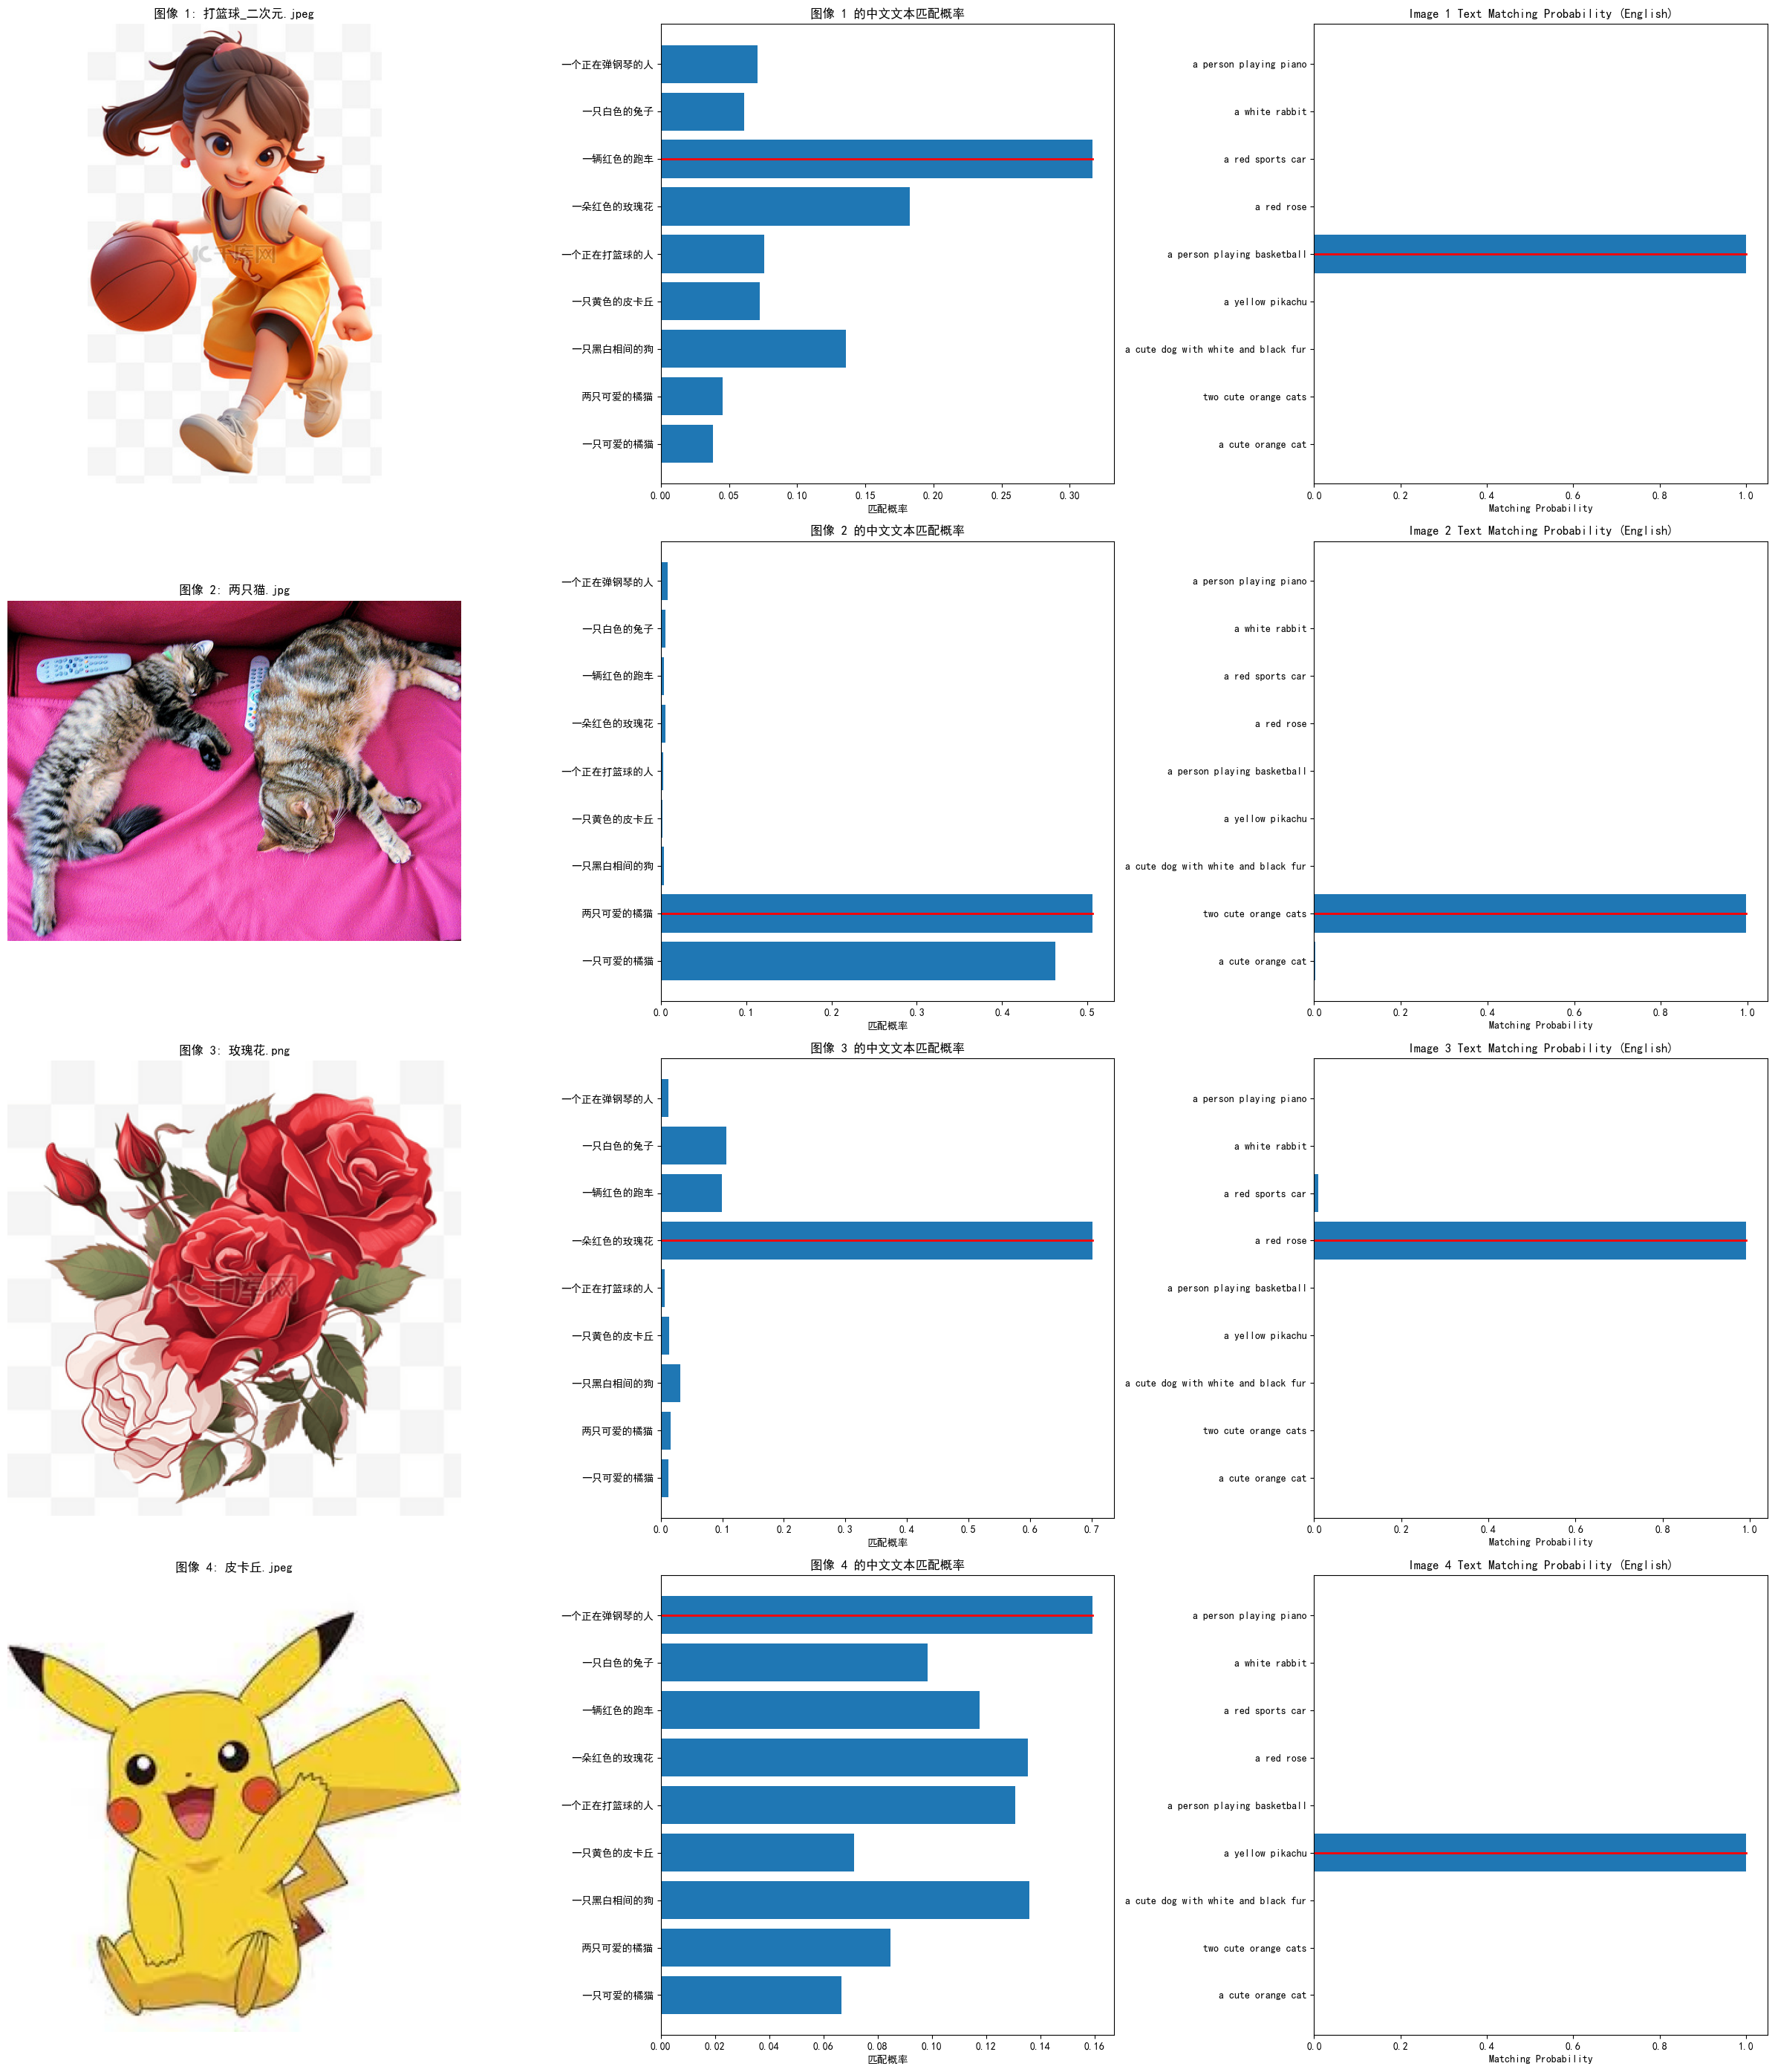

In [8]:
main(model, processor)

In [9]:
from transformers import ChineseCLIPProcessor, ChineseCLIPModel

print("加载Chinese-CLIP模型...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "OFA-Sys/chinese-clip-vit-base-patch16"
model = ChineseCLIPModel.from_pretrained(model_name).to(device)
processor = ChineseCLIPProcessor.from_pretrained(model_name)

# 支持的模型：https://huggingface.co/OFA-Sys
# https://github.com/OFA-Sys/Chinese-CLIP
# 1. OFA-Sys/chinese-clip-rn50
# 2. OFA-Sys/chinese-clip-vit-base-patch16
# 3. OFA-Sys/chinese-clip-vit-large-patch14
# 4. OFA-Sys/chinese-clip-vit-large-patch14-336px
# 5. OFA-Sys/chinese-clip-vit-huge-patch14

加载Chinese-CLIP模型...


In [10]:
# 定义要分词的文本
text = "一只可爱的橘猫"
# 使用处理器的分词器进行分词
inputs = processor.tokenizer(text, return_tensors="pt")
# 获取分词后的输入 ID
input_ids = inputs["input_ids"].squeeze()
# 将输入 ID 转换为分词结果
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

text = "a cute orange cat"
inputs = processor.tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].squeeze()
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['[CLS]', '一', '只', '可', '爱', '的', '橘', '猫', '[SEP]']
['[CLS]', 'a', 'cut', '##e', 'orange', 'cat', '[SEP]']


In [11]:
print(f"模型路径: {model.config._name_or_path}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
print(f"词表大小: {model.config.text_config.vocab_size}")

模型路径: OFA-Sys/chinese-clip-vit-base-patch16
模型参数量: 188.26M
词表大小: 21128


处理中文和英文文本...


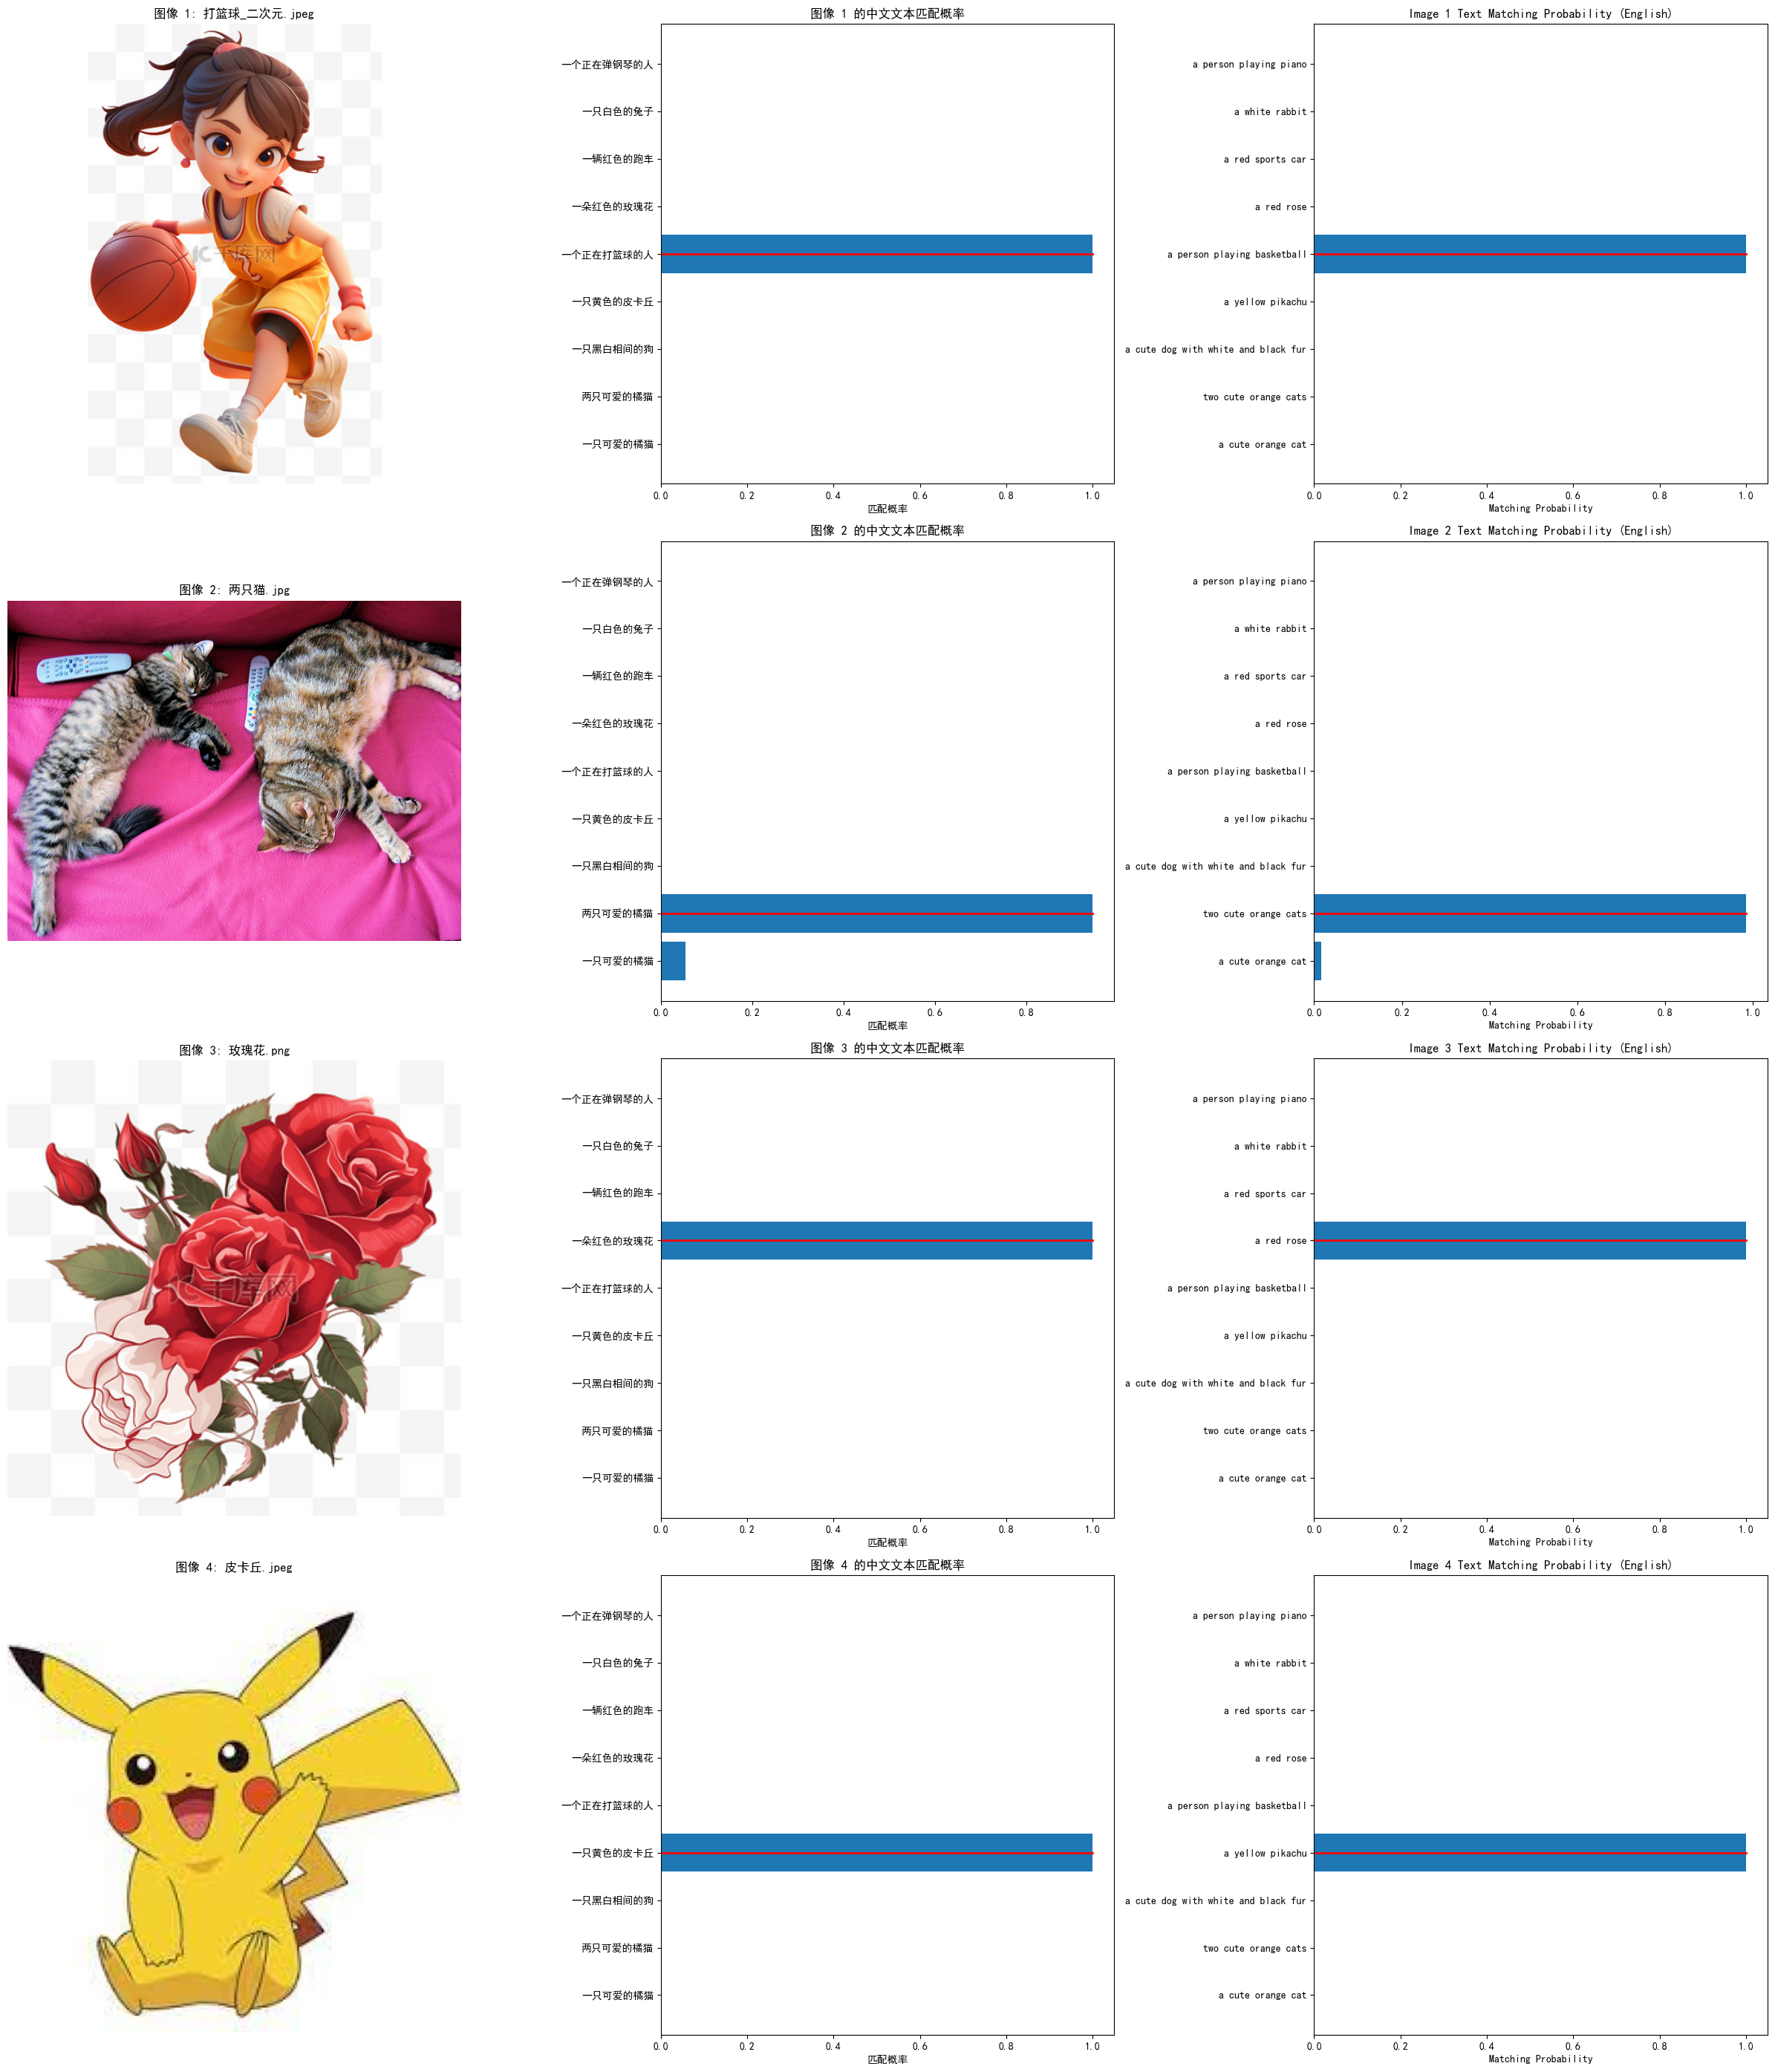

In [12]:
main(model, processor)

结论：
1. Hugging Face的预训练CLIP模型，英文的图文匹配效果更好。
2. 阿里开源的Chinese-CLIP模型，中/英文的图文匹配效果都不错。
3. HF CLIP tokenizer 是 BBPE，词表大小为 49408
4. Chinese-CLIP 的 tokenizer 则是 BPE，词表大小是 21128


处理中文和英文文本...


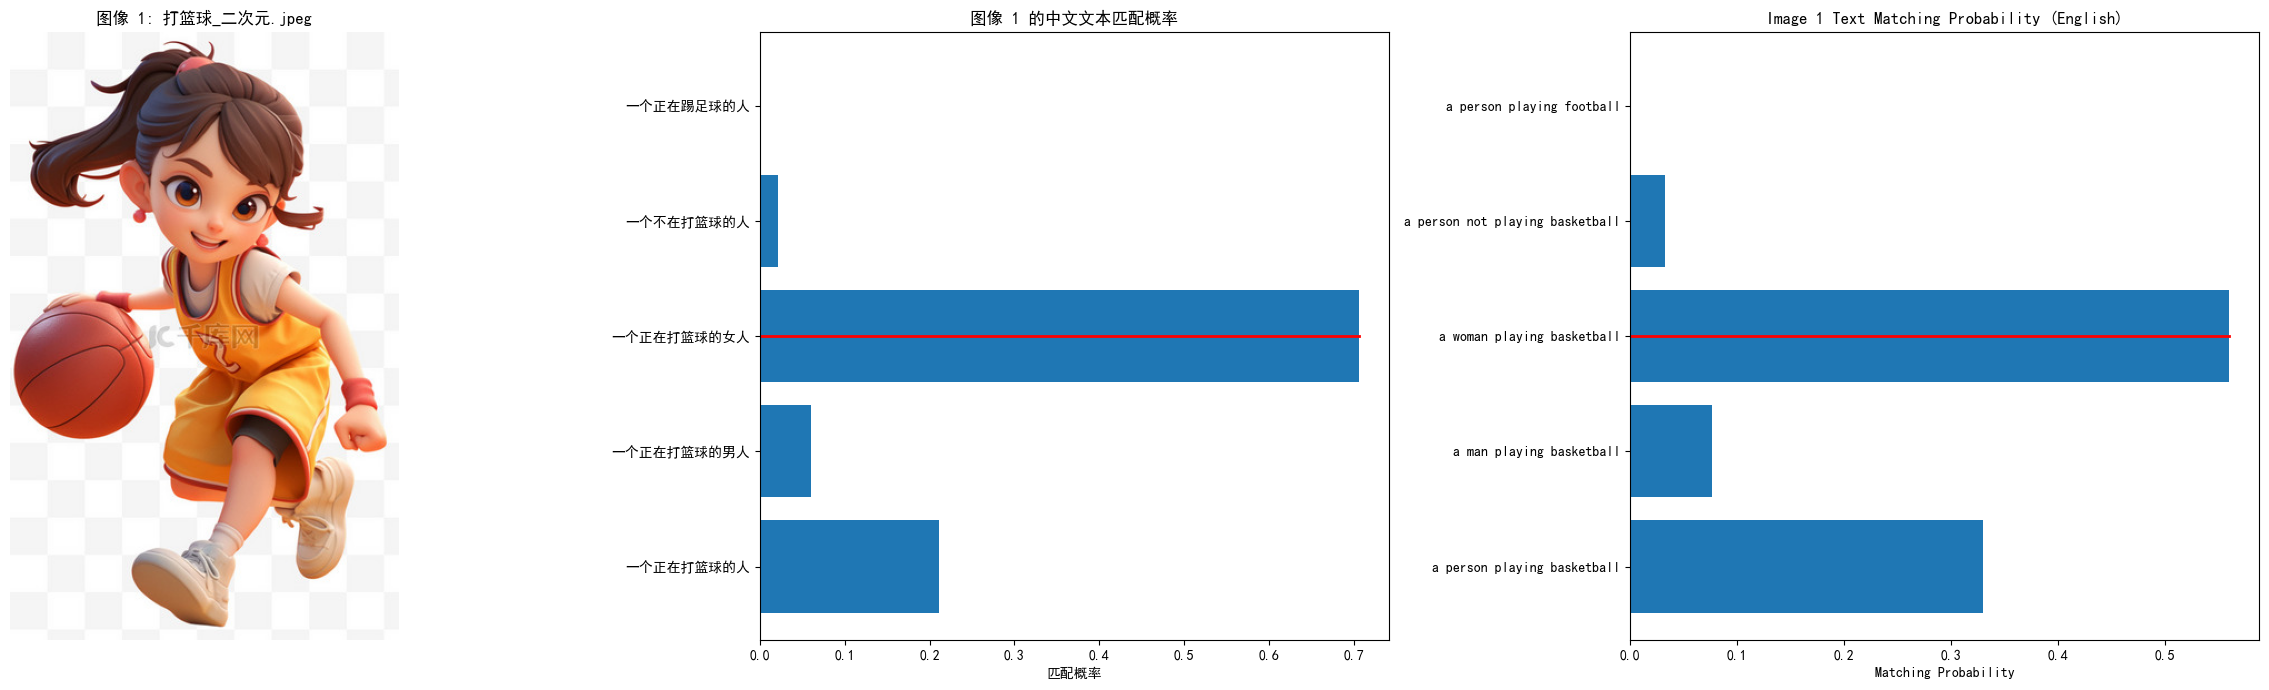

In [13]:
# 用chinese-clip模型

image_paths = [
    "./images/打篮球_二次元.jpeg",
]    

# 加载图像
images = []
img = load_image_from_path(image_paths[0])
if img:
    images.append(img)

if not images:
    print("错误：没有找到任何有效的图像文件")

# 准备文本描述
texts_zh = [
    "一个正在打篮球的人",
    "一个正在打篮球的男人",
    "一个正在打篮球的女人",
    # "一个正在打篮球的二次元角色",
    "一个不在打篮球的人",
    "一个正在踢足球的人",
]

texts_en = [
    "a person playing basketball",
    "a man playing basketball", 
    "a woman playing basketball",
    # "an anime character playing basketball",
    "a person not playing basketball",
    "a person playing football",
]

print("处理中文和英文文本...")
# 处理中文文本
inputs_zh = processor(images=images, text=texts_zh, return_tensors="pt", padding=True).to(device)
outputs_zh = model(**inputs_zh)
logits_per_image_zh = outputs_zh.logits_per_image
probs_zh = logits_per_image_zh.softmax(dim=1)

# 处理英文文本
inputs_en = processor(images=images, text=texts_en, return_tensors="pt", padding=True).to(device)
outputs_en = model(**inputs_en)
logits_per_image_en = outputs_en.logits_per_image
probs_en = logits_per_image_en.softmax(dim=1)

# 使用matplotlib可视化结果
visualize_results(images, image_paths, texts_zh, texts_en, probs_zh, probs_en)

In [15]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
if image.mode in ['RGBA', 'LA']: 
    image = image.convert('RGB')
pixel_tensors = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
print(pixel_tensors.shape) # torch.Size([1, 3, 224, 224])
with torch.no_grad():
    outputs = model.vision_model(pixel_values=pixel_tensors)
    print(outputs.last_hidden_state.shape) # torch.Size([1, 197, 768])
    # ! 去掉CLS token
    img_embedding = outputs.last_hidden_state[:, 1:, :].squeeze()
    print(img_embedding.shape) # torch.Size([196, 768])

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 768])
torch.Size([196, 768])


: 